In [12]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
def add_to_dict(data_dict,data,filename):
    if filename in data_dict['fn']:
        # print(f'File duplicated: {filename}' )
        pass
    else:
        data_dict['fn'].append(filename)
        L_list=np.arange(*data['args'].L)
        p_ctrl_list=np.round(np.linspace(data['args'].p_ctrl[0],data['args'].p_ctrl[1],int(data['args'].p_ctrl[2])),3)
        p_proj_list=np.round(np.linspace(data['args'].p_proj[0],data['args'].p_proj[1],int(data['args'].p_proj[2])),3)
        for key in set(data.keys())-set(['args']):
            for L_idx,L in enumerate(L_list):
                for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
                    for p_proj_idx,p_proj in enumerate(p_proj_list):
                            observations=data[key][L_idx,p_ctrl_idx,p_proj_idx]
                            if torch.is_tensor(observations):
                                # observations=observations.cpu().tolist()
                                observations=observations.cpu().numpy()
                            params=(key,L,p_ctrl,p_proj)
                            if params in data_dict:
                                # data_dict[params]=data_dict[params]+observations
                                data_dict[params]=np.r_[data_dict[params],observations]
                                # data_dict[params].append(observations)
                            else:
                                data_dict[params]=observations
                                # data_dict[params]=[observations]

In [3]:
def convert_pd(data_dict):
    index = pd.MultiIndex.from_tuples([key for key in data_dict.keys() if key!='fn'], names=['Metrics','L', 'p_ctrl', 'p_proj'])
    df = pd.DataFrame({'observations': [val for key,val in data_dict.items() if key!='fn']}, index=index)
    return df

In [4]:
import scipy

In [5]:
def logminusexp(a,b):
    assert a.shape==b.shape, f'shape mismatch: {a.shape} {b.shape}'
    assert np.all(a>=b), f'not all a>=b: {a} {b}'
    return a+np.log1p(-np.exp(b-a))

In [6]:
def sample_Born_tensor(log_p_r,log_p_r_):
    return torch.exp(torch.logsumexp(log_p_r,dim=1)-torch.logsumexp(log_p_r_,dim=1))

In [7]:
def Chi_(d_pd,p_ctrl_list,p_proj_list,L_list,N_C=None,N_m=None):
    Chi_se_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
    Chi_mean_map=np.zeros((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0]))
    for L_idx,L in enumerate(L_list):
        for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
            for p_proj_idx,p_proj in enumerate(p_proj_list):
                d_pd_tmp=d_pd.xs(key=L,level='L').xs(key=p_ctrl,level='p_ctrl').xs(key=p_proj,level='p_proj')
                log_r=torch.tensor(d_pd_tmp.loc['log_r']['observations'])
                log_r_=torch.tensor(d_pd_tmp.loc['log_r_']['observations'])
                if N_C is not None:
                    indices = torch.randint(0, log_r.shape[0], (N_C,))
                    log_r=log_r[indices]
                    log_r_=log_r_[indices]
                if N_m is not None:
                    indices = torch.randint(0, log_r_.shape[1], (N_m,))
                    log_r=log_r[:,indices]
                    log_r_=log_r_[:,indices]
                Chi_mean_map[L_idx,p_ctrl_idx,p_proj_idx]=sample_Born_tensor(log_r,log_r_).mean()
                Chi_se_map[L_idx,p_ctrl_idx,p_proj_idx]=sample_Born_tensor(log_r,log_r_).std()/np.sqrt(len(d_pd_tmp.loc['log_r'][0]))
    return Chi_mean_map,Chi_se_map

# xj=0

In [8]:
32*40

1280

In [30]:
dirpath='XEB/1_Encoding'

In [78]:
L_list=np.array([6,8,10,12,14])

[en[L]*s[L] for L in L_list]

[320, 640, 1280, 1280, 135]

In [64]:
d_0_pctrl_encoding_dict={'fn':[]}
en={6:320,8:160,10:40,12:20,14:5}
s={6:1,8:4,10:32,12:64,14:27}
L_list=np.array([6,8,10,12,14])
for L in L_list:
    for seed in range(s[L]):
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.26,0.36,11)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{seed}_seedC{seed}_64_XEB_encoding.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_0_pctrl_encoding_dict,save_dict,fn)

d_0_pctrl_encoding_dict_2={'fn':[]}
for L in [12,]:
    for seed in list(range(64)):
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.26,0.36,11)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{seed+1}_seedC{seed}_64_XEB_encoding.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_0_pctrl_encoding_dict_2,save_dict,fn)


for key, val in d_0_pctrl_encoding_dict_2.items(): 
    if key!='fn':
        d_0_pctrl_encoding_dict[key]=np.c_[d_0_pctrl_encoding_dict[key],val]
d_pd=convert_pd(d_0_pctrl_encoding_dict)

In [72]:
p_ctrl_list=np.round(np.linspace(0.26,0.36,11),2)
p_proj_list=np.round(np.linspace(0,0,1),3)
Chi_mean_map,Chi_se_map=Chi_(d_pd=d_pd,p_proj_list=p_proj_list,p_ctrl_list=p_ctrl_list,L_list=L_list)

In [73]:
p_ctrl_list[:-1]

array([0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35])

In [74]:
Chi_mean_map[L_idx,:-2,0]

array([0.68879551, 0.66707808, 0.64339972, 0.62931424, 0.61168492,
       0.59713066, 0.58934301, 0.57329464, 0.57239127])

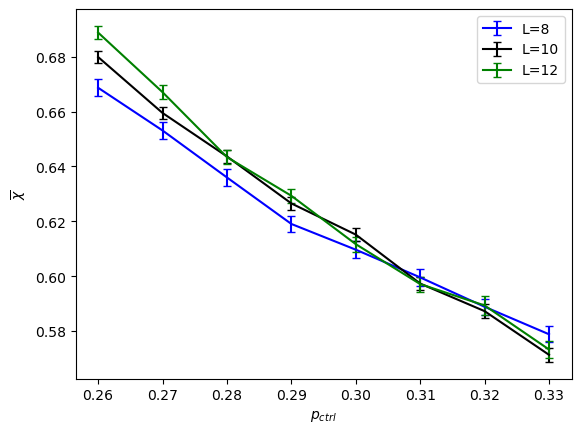

In [77]:
fig,ax=plt.subplots()
color_list=['r','b','k','g','y']
for L_idx,L in enumerate(L_list[:-1]):
    if L>6:
        ax.errorbar(p_ctrl_list[:-3],Chi_mean_map[L_idx,:-3,0],yerr=Chi_se_map[L_idx,:-3,0],label=f'L={L}',capsize=3,color=color_list[L_idx])
ax.legend()
ax.set_xlabel(r'$p_{ctrl}$')
ax.set_ylabel(r'$\overline{\chi}$')
fig.savefig('XEB_pproj_0.pdf')

# xj=0, pctrl=0

In [45]:
d_encoding_dict={'fn':[]}
en={8:320,10:80,12:20}
s={8:1,10:8,12:8}
L_list=np.array([8,10,12])
for L in L_list:
    for seed in range(s[L]):
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB_encoding.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_encoding_dict,save_dict,fn)
d_pd=convert_pd(d_encoding_dict)

In [46]:
p_proj_list=np.round(np.linspace(0.1,0.25,11),3)
p_ctrl_list=np.round(np.linspace(0,0,1),3)
Chi_mean_map,Chi_se_map=Chi_(d_pd=d_pd,p_proj_list=p_proj_list,p_ctrl_list=p_ctrl_list,L_list=L_list)

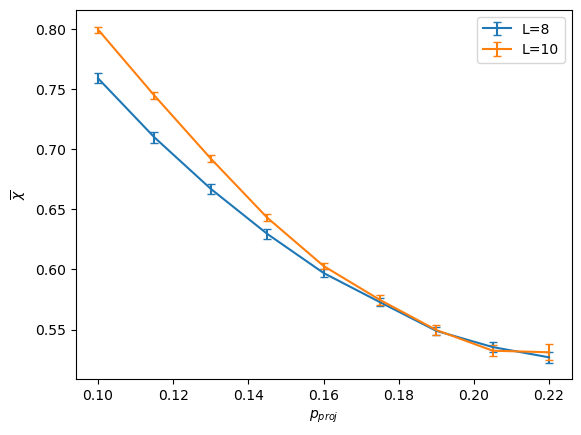

In [47]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list[:-1]):
    ax.errorbar(p_proj_list[:-2],Chi_mean_map[L_idx,0,:-2],yerr=Chi_se_map[L_idx,0,:-2],label=f'L={L}',capsize=3)
plt.legend()
ax.set_xlabel(r'$p_{proj}$')
ax.set_ylabel(r'$\overline{\chi}$')
fig.savefig('XEB_pctrl_0.pdf')

# xj=0, pctrl=0, start from Haar random

In [ ]:
d_dict={'fn':[]}
en={8:640,10:160,12:40}
s={8:1,10:16,12:3}
for L in [8,10,]:
    for seed in range(s[L]):
        # fn=f'CT_En2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_64_XEB.pickle'
        # fn=f'CT_En400_Enm2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        fn=f'CT_En{en[L]}_Enm2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_dict,save_dict,fn)

for L in [12,]:
    for seed in range(32):
        # fn=f'CT_En2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_64_XEB.pickle'
        # fn=f'CT_En400_Enm2000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        fn=f'CT_En{14}_Enm8000_pctrl(0.00,0.00,1)_pproj(0.10,0.25,11)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_dict,save_dict,fn)

for L in [10,]:
    for seed in range(16,44):
        fn=f'CT_En{en[L]}_Enm2000_pctrl(0.00,0.00,1)_pproj(0.16,0.25,7)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed}_seedC{seed}_64_XEB.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_dict,save_dict,fn)

d2_dict={'fn':[]}
for L in [10,]:
    for seed in list(range(0,44)):
        fn=f'CT_En{en[L]}_Enm2000_pctrl(0.00,0.00,1)_pproj(0.16,0.25,7)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed+1}_seedC{seed}_64_XEB.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d2_dict,save_dict,fn)

d3_dict={'fn':[]}
for L in [10,]:
    for seed in list(range(0,44)):
        try:
            fn=f'CT_En{en[L]}_Enm2000_pctrl(0.00,0.00,1)_pproj(0.16,0.25,7)_L({L},{L+2},2)_xj(1-3,2-3)_seed{seed+2}_seedC{seed}_64_XEB.pickle'
            with open(os.path.join(dirpath,fn),'rb') as f:
                save_dict=pickle.load(f)
            add_to_dict(d3_dict,save_dict,fn)
        except:
            print(f'File missing: {fn}')

for key, val in d2_dict.items(): 
    if key!='fn':
        d_dict[key]=np.c_[d_dict[key],val]
for key, val in d3_dict.items(): 
    if key!='fn':
        d_dict[key]=np.c_[d_dict[key],val]
d_pd=convert_pd(d_dict)

In [57]:
p_proj_list=np.round(np.linspace(0.1,0.25,11),3)
p_ctrl_list=np.round(np.linspace(0,0,1),3)
Chi_mean_map,Chi_se_map=Chi_(d_pd=d_pd,p_proj_list=p_proj_list,p_ctrl_list=p_ctrl_list,L_list=L_list)

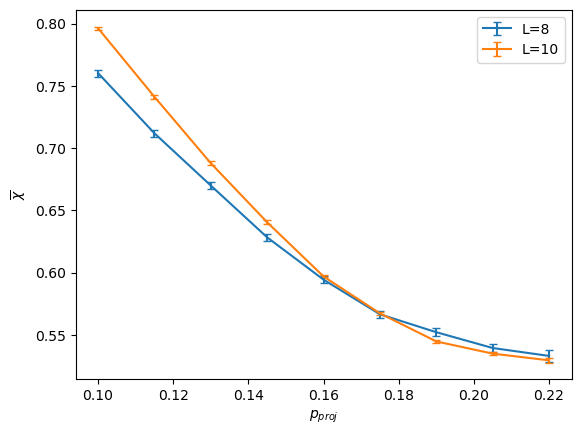

In [59]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list[:-1]):
    ax.errorbar(p_proj_list[:-2],Chi_mean_map[L_idx,0,:-2],yerr=Chi_se_map[L_idx,0,:-2],label=f'L={L}',capsize=3)
ax.legend()
ax.set_xlabel(r'$p_{proj}$')
ax.set_ylabel(r'$\overline{\chi}$')
fig.savefig('XEB_pctrl_0_no_encoding.pdf')

# xj=0, pctrl=0, haar encoding

In [ ]:
d_Haar_encoding_dict={'fn':[]}
en={8:320,10:80,12:20}
s={8:2,10:5,12:32}
L_list=np.array([8,10,12])
for L in L_list:
    for seed in range(s[L]):
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.00,0.00,1)_pproj(0.11,0.21,11)_L({L},{L+2},2)_xj(0)_seed{seed}_seedC{seed}_64_XEB_Haar_Encoding.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_Haar_encoding_dict,save_dict,fn)
d_pd=convert_pd(d_Haar_encoding_dict)

In [11]:
p_proj_list=np.round(np.linspace(0.11,0.21,11),3)
p_ctrl_list=np.round(np.linspace(0,0,1),3)
Chi_mean_map,Chi_se_map=Chi_(d_pd=d_pd,p_proj_list=p_proj_list,p_ctrl_list=p_ctrl_list,L_list=L_list)

Text(0, 0.5, '$\\overline{\\chi}$')

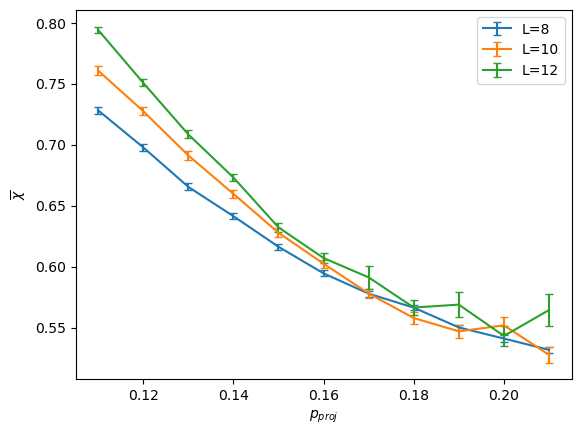

In [12]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list[:]):
    ax.errorbar(p_proj_list[:],Chi_mean_map[L_idx,0,:],yerr=Chi_se_map[L_idx,0,:],label=f'L={L}',capsize=3)
plt.legend()
ax.set_xlabel(r'$p_{proj}$')
ax.set_ylabel(r'$\overline{\chi}$')
# fig.savefig('XEB_pctrl_0.pdf')

In [68]:
np.stack(d_pd.xs(level='L',key=8).xs(level='p_proj',key=0).xs(level='Metrics',key='log_q').iloc[0]).shape

(1, 640, 4000)

# xj=1/3,2/3

In [ ]:
d_0_pctrl_encoding_dict={'fn':[]}
en={6:320,8:160,10:40,12:20,14:5}
s={6:1,8:4,10:32,12:64,14:27}
L_list=np.array([6,8,10,12,14])
for L in L_list:
    for seed in range(s[L]):
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.26,0.36,11)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{seed}_seedC{seed}_64_XEB_encoding.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_0_pctrl_encoding_dict,save_dict,fn)

d_0_pctrl_encoding_dict_2={'fn':[]}
for L in [12,]:
    for seed in list(range(64)):
        fn=f'CT_En{en[L]}_Enm4000_pctrl(0.26,0.36,11)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{seed+1}_seedC{seed}_64_XEB_encoding.pickle'
        with open(os.path.join(dirpath,fn),'rb') as f:
            save_dict=pickle.load(f)
        add_to_dict(d_0_pctrl_encoding_dict_2,save_dict,fn)


for key, val in d_0_pctrl_encoding_dict_2.items(): 
    if key!='fn':
        d_0_pctrl_encoding_dict[key]=np.c_[d_0_pctrl_encoding_dict[key],val]
d_pd=convert_pd(d_0_pctrl_encoding_dict)